<a href="https://colab.research.google.com/github/tjy2202/P.T/blob/main/Side_Project/Capstone/coronary_angiography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## get data, library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import display
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
import xgboost
import seaborn as sns

In [ ]:
# 이름          : 
# 나이_성별     : (personal data)
# 병원 번호     :
# 검사 날짜     : 
# 비고          :
# Img_bas_n     : Basal Image number
# TFC_start_b   : (Frame count)TFC start frame_basal
# TFCC_end_b    : (Frame count)TFc end frame_basal
# CCFC_start_b  : (Frame count)CCFC start frame_basal
# CCFC_end_b    : (Frame count)CCFS end frame_basal
# Img_hyp_n     : Hyperemic Image number
# TFC_start_h   : (Frame count)TFC start frame_hyperemic
# TFC_end_h     : (Frame count)TFc end frame_hyperemic
# CCFC_start_h  : (Frame count)CCFC start frame
# CCFS_end_h    : (Frame count)CCFS end frame
# TFC_bas       : (Frame total count)TIMI Frame Count_basal
# TFC_hyp       : (Frame total count)TIMI Frame Count_hyperemic
# CCFC_bas      : (Frame total count)Coronary Clearance Frame Count_basal
# CCFC_hyp      : (Frame total count)Coronary Clearance Frame Count_hyperemic
# HR            : (personal data)Heart rate
# CFR_Therm     : Coronary Flow Reserve_Thermodilution
# CFR_TFC       : CFR by TFC
# CFR_CCFC      : CFR by CCFC
# Tmn_bas       : (Label)Transit time_basal
# Tmn_hyp       : (Label)Transit time_basal
# Pa_bas        : Aortic pressure_basal
# Pd_bas        : Distal pressure_basal 
# Pa_hyp        : Aortic pressure_hyperemic
# Pd_hyp        : Distal pressure_hyperemic
# IMR           : Index of Microcirculatory resistance
# TFC*Pa        : 
# CCFC*Pa       : 
# Pd/Pa         : Pd/Pa_basal
# FFR           : Fractional Flow Reserve_hyperemic
# PCI           : 0=no, 1=yes
# Pd/Pa_pre     : Pre-PCI Pd/Pa
# FFR_pre       : Pre-PCI FFR
# HTN           : (personal data)Hypertension
# DM            : (personal data)Diabetes
# Smoking       : (personal data)0 = ?, 1 = ?
# Dyslipidemia  : (personal data)
# CVA Hx        : (personal data)
# Stent_total   : Stent number_total
# Stent_Lesion  : Stent number_lesion
# Stent_brand   : 
# Stent_size    : Stent_size_mean
# Stent_length  : Stent_length_sum
# CAD           : 1=1VD. 2=2VD. 3=3VD. 4=LM Dz
# Lesion        : 1=LAD, 2=LCX, 3=RCA, 4=LM
# Presentation  : 1=SA, 2=UA, 3=NSTEMI,4=STEMI ,5=Atypical CP ,6=Variant angina

# TFC, CCFC를 가지고 IMR, CFR 값과 대조-검증하여 조영상만으로 혈역학적 특성을 평가하는 모델을 개발.
# CFR_TFC =  TFC_bas / TFC_hyp
# CFR_CCFC를 =  CCFC를_bas / CCFC를_hyp
# CFR_Therm???

# IMR = (Pa_bas - Pd_bas) / Tnm_bas

## data preprocessing

In [ ]:
df = pd.read_excel('drive/MyDrive/project/sheet.xlsx')
df.columns = df.iloc[0,:].values
df = df.iloc[1:,1:]
df['age'], df['sex'] = np.reshape(df['나이_성별'].str.split('/').values.tolist(), (51,2)).T
require_index = ['age','sex', 'TFC_bas', 'TFC_hyp', 'CCFC_bas', 'CCFC_hyp', 'HR', 'HTN','DM','Smoking','Dyslipidemia','CVA Hx','Stent_total', 'Tmn_bas', 'Tmn_hyp']
df = df.loc[:,require_index]
df.dropna(inplace=True)
df['Stent_total'] = df['Stent_total'].replace(999,0)
df['sex'] = df['sex'].replace('M',0).replace('F',1)
df.iloc[:,[0,1,7,8,9,10,11,12]] = df.iloc[:,[0,1,7,8,9,10,11,12]].astype('category')
df.iloc[:,[2,3,4,5,6,13,14]] = df.iloc[:,[2,3,4,5,6,13,14]].astype(float)
df.head(10)

,age,sex,TFC_bas,TFC_hyp,CCFC_bas,CCFC_hyp,HR,HTN,DM,Smoking,Dyslipidemia,CVA Hx,Stent_total,Tmn_bas,Tmn_hyp
1,83,0,32.0,18.0,114.0,78.0,65.0,1,0,0,0,0,2,1.30,0.48
2,54,0,38.0,18.0,92.0,29.0,80.0,0,1,1,0,0,1,0.44,0.11
3,57,0,30.0,24.0,93.0,39.0,82.0,0,1,1,0,0,2,0.49,0.20
4,59,1,22.0,12.0,85.0,38.0,73.0,0,0,0,0,0,1,0.30,0.12
5,53,0,36.0,21.0,72.0,40.0,90.0,1,1,0,1,0,0,0.52,0.19
6,73,1,60.0,28.0,103.0,38.0,72.0,0,0,0,1,0,0,0.56,0.17
7,58,0,41.0,17.0,114.0,33.0,65.0,0,0,1,1,1,1,0.61,0.16
8,69,1,22.0,11.0,51.0,20.0,62.0,0,0,0,1,0,2,0.41,0.17
9,49,0,30.0,12.0,49.0,19.0,62.0,0,0,1,1,0,1,0.54,0.21
11,76,1,27.0,16.0,62.0,28.0,76.0,1,0,0,1,0,0,0.37,0.12


In [ ]:
df.dtypes

age             category
sex             category
TFC_bas          float64
TFC_hyp          float64
CCFC_bas         float64
CCFC_hyp         float64
HR               float64
HTN             category
DM              category
Smoking         category
Dyslipidemia    category
CVA Hx          category
Stent_total     category
Tmn_bas          float64
Tmn_hyp          float64
dtype: object

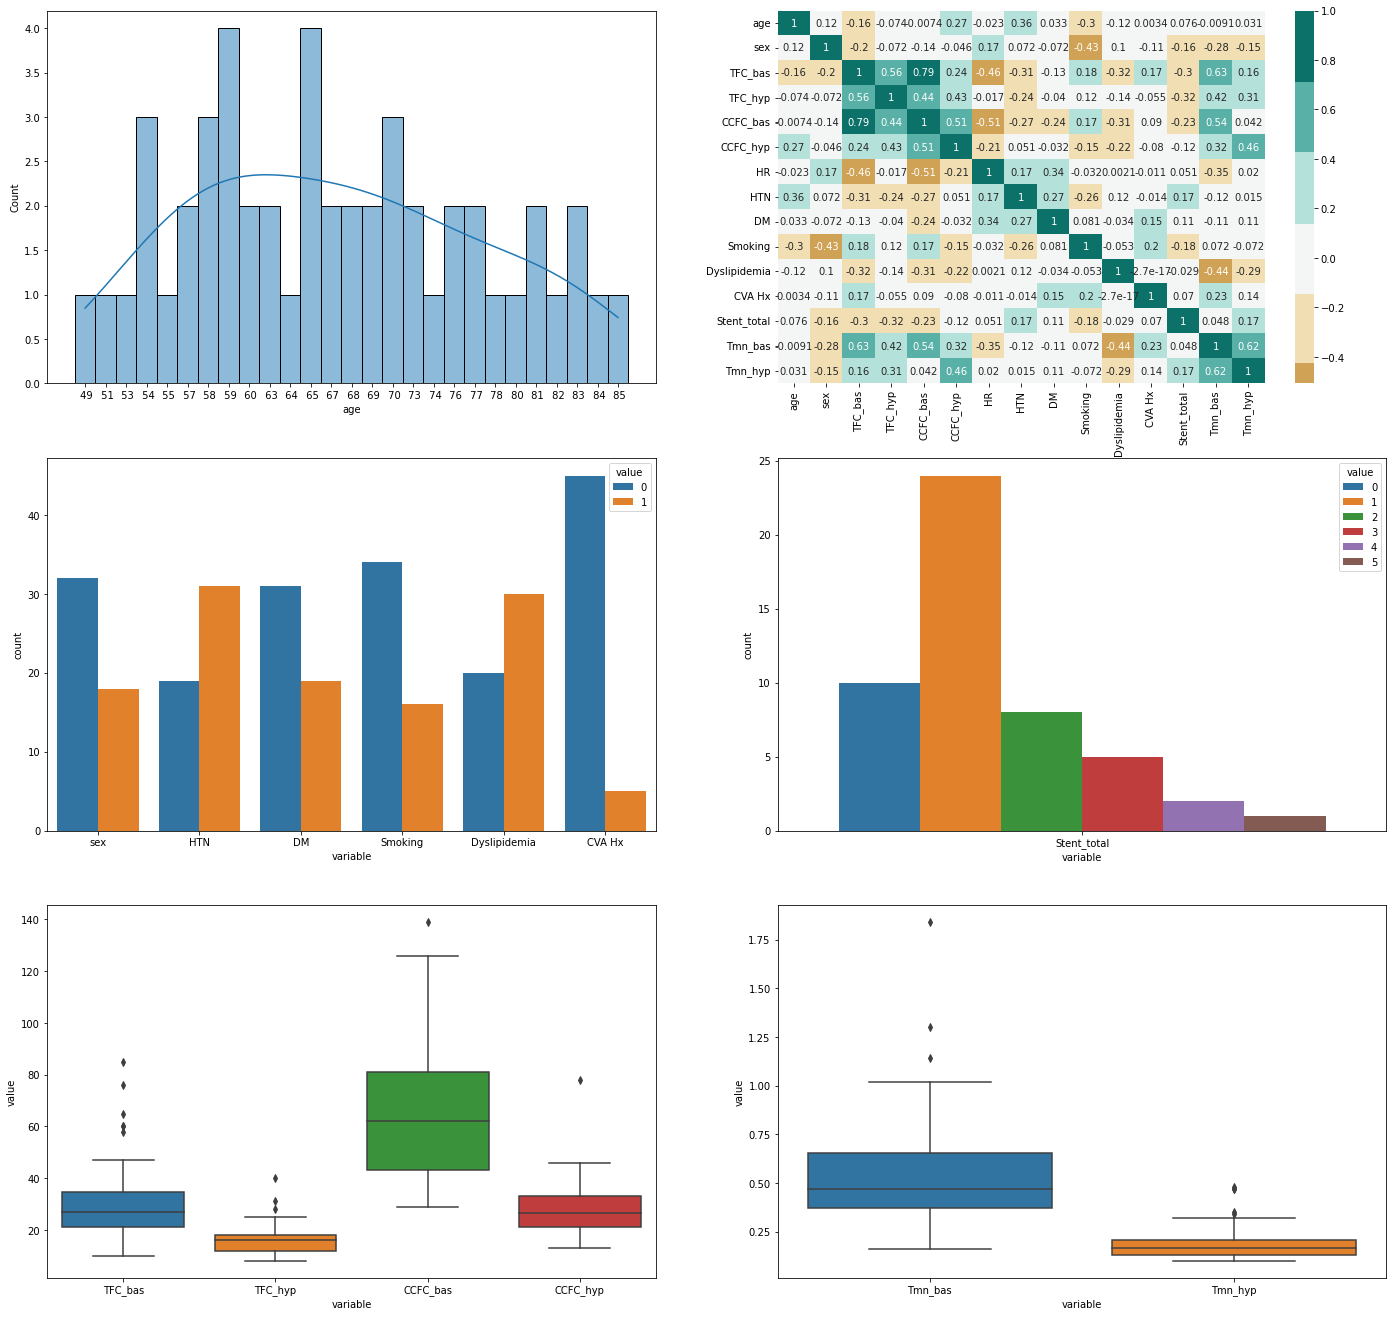

In [ ]:
plt.figure(figsize=(24,48))
plt.subplot(621)
# sns.countplot(df.age)
sns.histplot(data=df, x='age',kde=True)

plt.subplot(622)
m = df.astype(float)
sns.heatmap(m.corr(), annot=True, cmap=sns.color_palette('BrBG',7), center=0)

plt.subplot(623)
m = df.melt()
sns.countplot(data = m[m['variable'].isin(['sex','HTN','DM','Smoking','Dyslipidemia','CVA Hx'])], hue='value',x='variable')

plt.subplot(624)
m = df.melt()
sns.countplot(data = m[m['variable'].isin(['Stent_total'])], hue='value',x='variable')


plt.subplot(625)
m = df.melt()
m = m[m['variable'].isin(['TFC_bas','TFC_hyp','CCFC_bas','CCFC_hyp'])]
sns.boxplot(data=m, y='value',x='variable')

plt.subplot(626)
m = df.melt()
m = m[m['variable'].isin(['Tmn_bas','Tmn_hyp'])]
sns.boxplot(data=m, y='value',x='variable')

plt.show()

## EDA

In [ ]:
!pip install -q lazypredict

## select model

### before scaling

In [ ]:
X_bas, X_hyp  = df.iloc[:,[0,1,2,4,6,7,8,9,10,11,12]], df.iloc[:,[0,1,3,5,6,7,8,9,10,11,12]]
y_bas, y_hyp = df.iloc[:,-2].values.reshape(-1,1), df.iloc[:,-1].values.reshape(-1,1)

X_train_bas, X_test_bas, y_train_bas, y_test_bas = train_test_split(X_bas,y_bas,test_size=.2,random_state=100)
X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = train_test_split(X_hyp,y_hyp,test_size=.2,random_state=100)

y_train_bas = y_train_bas.reshape(-1)
y_test_bas = y_test_bas.reshape(-1)
y_train_hyp = y_train_hyp.reshape(-1)
y_test_hyp = y_test_hyp.reshape(-1)

In [ ]:
from IPython.display import display
display(X_bas.head(3))
display(X_hyp.head(3))

,age,sex,TFC_bas,CCFC_bas,HR,HTN,DM,Smoking,Dyslipidemia,CVA Hx,Stent_total
1,83,0,32.0,114.0,65.0,1,0,0,0,0,2
2,54,0,38.0,92.0,80.0,0,1,1,0,0,1
3,57,0,30.0,93.0,82.0,0,1,1,0,0,2


,age,sex,TFC_hyp,CCFC_hyp,HR,HTN,DM,Smoking,Dyslipidemia,CVA Hx,Stent_total
1,83,0,18.0,78.0,65.0,1,0,0,0,0,2
2,54,0,18.0,29.0,80.0,0,1,1,0,0,1
3,57,0,24.0,39.0,82.0,0,1,1,0,0,2


### select model

In [ ]:
from lazypredict.Supervised import LazyRegressor

lazy = LazyRegressor(verbose=0, predictions=True)

models1, predictions = lazy.fit(X_train_bas, X_test_bas, y_train_bas.reshape(-1), y_test_bas.reshape(-1))
models2, predictions = lazy.fit(X_train_hyp, X_test_hyp, y_train_hyp.reshape(-1), y_test_hyp.reshape(-1))

100%|██████████| 42/42 [00:01<00:00, 23.95it/s]


[01:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [00:01<00:00, 26.24it/s]

[01:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
display(models1.sort_values('RMSE', ascending=True).head(3))
display(models2.sort_values('RMSE', ascending=True).head(3))

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLars,5.51,-0.00,0.22,0.01
ElasticNet,5.51,-0.00,0.22,0.01
Lasso,5.51,-0.00,0.22,0.01


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,4.22,0.28,0.09,0.01
GradientBoostingRegressor,4.27,0.27,0.09,0.07
XGBRegressor,4.96,0.12,0.10,0.03


### test

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
import xgboost

kfold = KFold(n_splits=5, shuffle = True)

lasso = LassoLars()
scores = cross_validate(lasso, X_bas, y_bas, cv=kfold, scoring={'rmse':'neg_mean_squared_error',
                                                                'r2':'r2'})
rmse_score = np.sqrt(-1 * scores['test_rmse'])
r2_score = scores['test_r2']

print(f"rmse_mean : {rmse_score.mean():.2f}, {rmse_score}")
print(f"r2_mean : {r2_score.mean():.2f}, {r2_score}")

dtr = DecisionTreeRegressor()
scores = cross_validate(dtr, X_hyp, y_hyp, cv=kfold, scoring={'rmse':'neg_mean_squared_error',
                                                              'r2':'r2'})
rmse_score = np.sqrt(-1 * scores['test_rmse'])
r2_score = scores['test_r2']

print(f"rmse_mean : {rmse_score.mean():.2f}, {rmse_score}")
print(f"r2_mean : {r2_score.mean():.2f}, {r2_score}")

rmse_mean : 0.29, [0.19314761 0.19680971 0.26921228 0.32525999 0.47027146]
r2_mean : -0.10, [-0.17755121 -0.00036318 -0.09036167 -0.14644628 -0.07279322]
rmse_mean : 0.09, [0.12969194 0.04909175 0.05700877 0.11414903 0.11606033]
r2_mean : -0.64, [-0.86474501  0.76838059  0.74587536 -1.86436579 -1.96109035]


In [ ]:
pd.DataFrame([dtr.fit(X_bas, y_bas).predict(X_bas), y_bas.reshape(-1)]).T

,0,1
0,1.30,1.30
1,0.44,0.44
2,0.49,0.49
3,0.30,0.30
4,0.52,0.52
5,0.56,0.56
6,0.61,0.61
7,0.41,0.41
8,0.54,0.54
9,0.37,0.37


### after scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_X_bas = scaler.fit_transform(X_bas)
scaled_X_hyp = scaler.fit_transform(X_hyp)
scaled_y_bas = scaler.fit_transform(y_bas)
scaled_y_hyp = scaler.fit_transform(y_hyp)

X_train_bas, X_test_bas, y_train_bas, y_test_bas = train_test_split(scaled_X_bas,scaled_y_bas,test_size=.2,random_state=100)
X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = train_test_split(scaled_X_hyp,scaled_y_hyp,test_size=.2,random_state=100)

y_train_bas = y_train_bas.reshape(-1)
y_test_bas = y_test_bas.reshape(-1)
y_train_hyp = y_train_hyp.reshape(-1)
y_test_hyp = y_test_hyp.reshape(-1)

In [ ]:
lasso = LassoLars()
scores = cross_validate(lasso, scaled_X_bas, scaled_y_bas, cv=kfold, scoring={'rmse':'neg_mean_squared_error',
                                                                              'r2':'r2'})
rmse_score = np.sqrt(-1 * scores['test_rmse'])
r2_score = scores['test_r2']
print(f"rmse_mean : {rmse_score.mean():.2f}, {rmse_score}")
print(f"r2_mean : {r2_score.mean():.2f}, {r2_score}")


dtr = DecisionTreeRegressor()
scores = cross_validate(dtr, scaled_X_hyp, scaled_y_hyp, cv=kfold, scoring={'rmse':'neg_mean_squared_error',
                                                                              'r2':'r2'})
rmse_score = np.sqrt(-1 * scores['test_rmse'])
r2_score = scores['test_r2']
print(f"rmse_mean : {rmse_score.mean():.2f}, {rmse_score}")
print(f"r2_mean : {r2_score.mean():.2f}, {r2_score}")

rmse_mean : 0.99, [0.75367857 1.09597864 0.67934431 1.46383317 0.95900985]
r2_mean : -0.36, [-0.69032606 -0.03359807 -0.8828125  -0.14886404 -0.05678207]
rmse_mean : 1.11, [1.27985277 1.21043811 0.85973081 1.12041995 1.06196992]
r2_mean : -0.42, [-0.45921835 -0.88612646  0.42034405  0.0069785  -1.17771639]


### select model

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lazypredict.Supervised import LazyRegressor

lazy = LazyRegressor(verbose=0, predictions=True)

models1, predictions = lazy.fit(X_train_bas, X_test_bas, y_train_bas.reshape(-1), y_test_bas.reshape(-1))
models2, predictions = lazy.fit(X_train_hyp, X_test_hyp, y_train_hyp.reshape(-1), y_test_hyp.reshape(-1))

display(models1.sort_values('RMSE', ascending=True).head(3))
display(models2.sort_values('RMSE', ascending=True).head(3))

SVR
max  : 0.5157571868537152
mean : -1.816711928103235
list : [  0.38050995  -1.19740833   0.51575719   0.44109392   0.32256577
  -3.35543609   0.35742444  -1.27533491   0.44035265   0.03590711
   0.13856146 -24.45484455  -0.80852805   0.17102374   0.34540092
  -2.19726972  -1.14686959   0.46454451  -5.86221245   0.35052346]


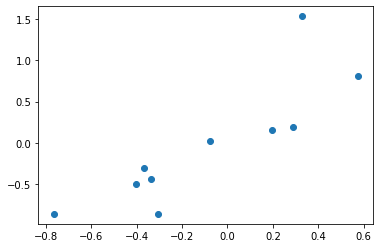

  0%|          | 0/10 [00:00<?, ?it/s]

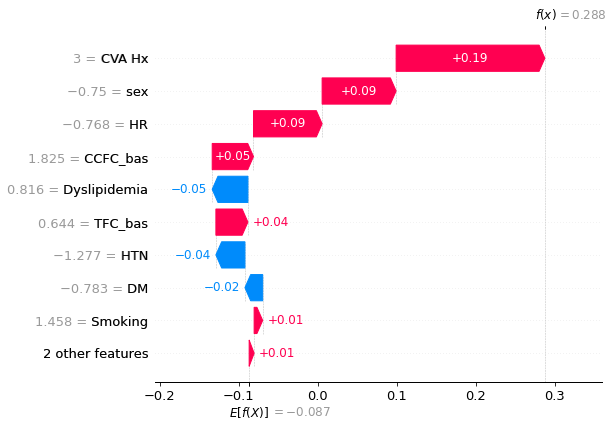

In [ ]:
import shap 

#####
from sklearn.svm import SVR
# 돌릴때마다 값이 많이 튐. 
estimator = SVR()
print('SVR')
cv = cross_validate(estimator, scaled_X_bas, scaled_y_bas, cv=KFold(20, shuffle=True), scoring=['r2'], return_train_score=False, return_estimator=True)
print(f"max  : {cv['test_r2'].max()}")
print(f"mean : {cv['test_r2'].mean()}")
print(f"list : {cv['test_r2']}")

model = cv['estimator'][cv['test_r2'].tolist().index(max(cv['test_r2']))]
plt.scatter(model.predict(X_test_bas), y_test_bas)
plt.show()

d = pd.DataFrame(X_test_bas, columns=X_bas.columns)
explainer = shap.KernelExplainer(model.predict, d)
shap_values = explainer.shap_values(d)
# sv = shap.waterfall_plot(shap_values[0])

exp = shap.Explanation(shap_values, explainer.expected_value, data=d.values, feature_names=d.columns)
shap.plots.waterfall(exp[0])

GradientBoostingRegressor
max  : 0.8828253671879959
mean : -25.93006716658033
list : [-6.39742307e-01 -3.65578665e+01 -2.31778525e+00  1.82021887e-01
  4.16851783e-01  2.94675440e-03 -6.63550448e+01 -2.76449420e-01
 -2.38687972e+01 -1.44701108e+00 -1.57409591e+02 -6.57342747e+00
 -3.57252512e+00 -9.36514118e-01  8.82825367e-01 -1.45802458e+01
  6.68762881e-01 -1.22681654e+00 -1.98384846e+02 -6.60808961e+00]


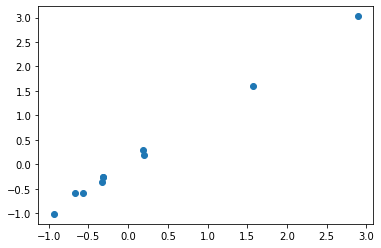

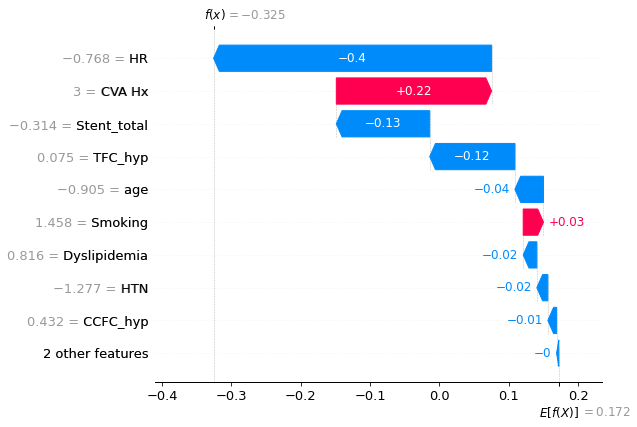

In [ ]:
#####
from sklearn.ensemble import GradientBoostingRegressor

estimator = GradientBoostingRegressor()
print('GradientBoostingRegressor')
cv = cross_validate(estimator, scaled_X_hyp, scaled_y_hyp, cv=KFold(20, shuffle=True), scoring=['r2'], return_train_score=False, return_estimator=True)
print(f"max  : {cv['test_r2'].max()}")
print(f"mean : {cv['test_r2'].mean()}")
print(f"list : {cv['test_r2']}")

model = cv['estimator'][cv['test_r2'].tolist().index(max(cv['test_r2']))]
plt.scatter(model.predict(X_test_hyp), y_test_hyp)
plt.show()


d = pd.DataFrame(X_test_hyp, columns=X_hyp.columns)
explainer = shap.Explainer(model, d)
shap_values = explainer(d)
shap.waterfall_plot(shap_values[0])

In [ ]:
pd.DataFrame([dtr.fit(scaled_X_bas, scaled_y_bas).predict(scaled_X_bas), scaled_y_bas.reshape(-1)]).T.sample(5)

In [ ]:
pd.DataFrame({'feature':X_hyp.columns ,'importance':dtr.fit(scaled_X_hyp, scaled_y_hyp).feature_importances_}).sort_values(by='importance',ascending=False)

In [ ]:
dtr.fit(X_train_hyp, y_train_hyp)
pd.DataFrame([dtr.predict(X_test_hyp), y_test_hyp.reshape(-1)]).T.head(10)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
print('RandomForestRegressor')
print(cross_validate(estimator, scaled_X_hyp, scaled_y_hyp, cv=KFold(5, shuffle=True), scoring=['r2'], return_train_score=False)['test_r2'].mean())
plt.scatter(estimator.fit(X_train_hyp, y_train_hyp).predict(X_test_hyp), y_test_hyp)

GradientBoostingRegressor
-1.0137020830157004


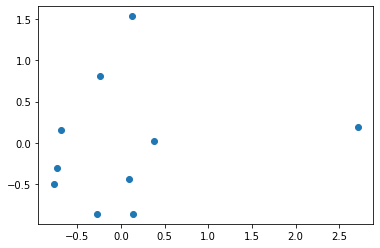

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

estimator = GradientBoostingRegressor()
print('GradientBoostingRegressor')
print(cross_validate(estimator, scaled_X_bas, scaled_y_bas, cv=KFold(5, shuffle=True), scoring=['r2'], return_train_score=False)['test_r2'].mean())
plt.scatter(estimator.fit(X_train_hyp, y_train_hyp).predict(X_test_bas), y_test_bas)

DecisionTreeRegressor
-1.5596992067748947


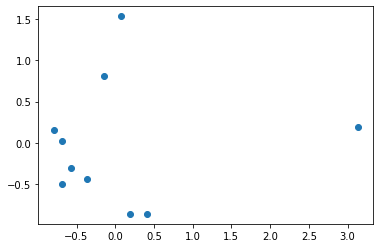

In [ ]:
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor()
print('DecisionTreeRegressor')
print(cross_validate(estimator, scaled_X_bas, scaled_y_bas, cv=KFold(5, shuffle=True), scoring=['r2'], return_train_score=False)['test_r2'].mean())
plt.scatter(estimator.fit(X_train_hyp, y_train_hyp).predict(X_test_bas), y_test_bas)

XGBRegressor
[14:00:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-0.27731648653466756
[14:00:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


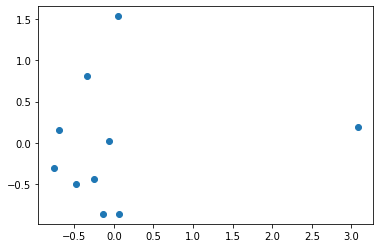

In [ ]:
from xgboost import XGBRegressor

estimator = XGBRegressor()
print('XGBRegressor')
print(cross_validate(estimator, scaled_X_bas, scaled_y_bas, cv=KFold(5, shuffle=True), scoring=['r2'], return_train_score=False)['test_r2'].mean())
plt.scatter(estimator.fit(X_train_hyp, y_train_hyp).predict(X_test_bas), y_test_bas)

## train & hyperparameters tuning

In [ ]:
# # !pip install -q scikit-optimize

from sklearn.preprocessing import StandardScaler
       

# cv = ShuffleSplit(n_splits=5 , test_size=0.3, random_state=42)
# pipe_xgr = Pipeline([
#                 ('scale', StandardScaler()),
#                 ('fit', xgboost.XGBRFRegressor())])
# pipe_linear = Pipeline([
#                 ('poly', PolynomialFeatures()),
#                 ('fit', LinearRegression())])
# pipe_lasso = Pipeline([
#                 ('poly', PolynomialFeatures()),
#                 ('fit', Lasso(random_state = 42))])
# pipe_ridge = Pipeline([
#                 ('poly', PolynomialFeatures()),
#                 ('fit', Ridge(random_state = 42))])
# pipe_pca = Pipeline([
#                 ('pca', PCA()),
#                 ('fit', Ridge(random_state = 42))])
# pipe_pls = Pipeline([
#                 ('fit', PLS())])
# pipe_gbr = Pipeline([
#                 ('fit', GBR())])
# pipe_rfr = Pipeline([
#                 ('fit', RFR())])
# pipe_svr = Pipeline([
#                 ('fit', SVR())])
# pipe_KR = Pipeline([
#                 ('fit', KernelRidge())])
                 
                 
# ### 
# grid_params_xgr = [{
# }]
# grid_params_linear = [{
#     "poly__degree" : np.arange(1,3), 
#     "fit__fit_intercept" : [True, False], 
# }]
# grid_params_lasso = [{
#     "poly__degree" : np.arange(1,3),
#     "fit__tol" : np.logspace(-5,0,10) ,
#     "fit__alpha" : np.logspace(-5,1,10) ,     
#                      }]
# grid_params_pca = [{
#     "pca__n_components" : np.arange(2,8)
# }]
# grid_params_ridge = [{
#     "poly__degree" : np.arange(1,3),
#     "fit__alpha" : np.linspace(2,5,10) ,
#     "fit__solver" : [ "cholesky","lsqr","sparse_cg"] ,
#     "fit__tol" : np.logspace(-5,0,10) ,
#                      }]
# grid_params_pls = [{
#     "fit__n_components" : np.arange(2,8)
# }]
# min_samples_split_range = [0.5, 0.7 , 0.9]

# grid_params_gbr =[{
#     "fit__max_features" : ["sqrt","log2"] ,
#     "fit__loss" : ["ls","lad","huber","quantile"] , 
#     "fit__max_depth" : [5,6,7,8] ,
#     "fit__min_samples_split" : min_samples_split_range ,
# }]
# grid_params_rfr =[{
#     "fit__max_features" : ["sqrt","log2"] , 
#     "fit__max_depth" : [5,6,7,8] ,
#     "fit__min_samples_split" : min_samples_split_range ,
# }]
# grid_params_svr =[{
#     "fit__kernel" : ["rbf", "linear"] ,
#     "fit__degree" : [2, 3, 5] , 
#     "fit__gamma" : np.logspace(-5,1,10) ,
# }]
# grid_params_KR =[{
#     "fit__kernel" : ["rbf","linear"] , 
#     "fit__gamma" : np.logspace(-5,1,10) ,
# }]
# pipe = [
#     pipe_xgr,pipe_linear , pipe_lasso ,  pipe_pca ,
#     pipe_ridge , pipe_pls , pipe_gbr , 
#     pipe_rfr , pipe_svr , pipe_KR 
# ]

# params = [
#     grid_params_xgr, grid_params_linear , grid_params_lasso , grid_params_pca,
#     grid_params_ridge , grid_params_pls , grid_params_gbr ,
#     grid_params_rfr , grid_params_svr , grid_params_KR
# ]

# jobs = 20

# grid_dict = {
#     0: 'XGR',
#     1: 'Linear', 
#     2: 'Lasso', 
#     3: 'pca regression' , 
#     4: 'Ridge' ,
#     5: 'PLSRegression',
#     6: "GradientDescentRegressor" ,
#     7: "RandomForestRegressor" ,
#     8: "SupportVectorRegressor" ,
#     9: "Kernel RidgeRegression"
#             }

# model_mse = {}
# model_r2 = {}
# model_best_params = {}


# for idx , (param , model) in enumerate(zip(params , pipe)) :
#     search = GridSearchCV(model, param, scoring  = make_scorer(mean_squared_error, greater_is_better=False), 
#                           cv=cv , n_jobs=jobs , verbose=-1 )
#     search.fit(X_train_bas , y_train_bas)
#     y_pred = search.predict(X_test_bas)
#     model_mse[grid_dict.get(idx)] = mse(y_test_bas, y_pred) ** .5
#     model_r2[grid_dict.get(idx)] = r2(y_test_bas, y_pred)  
#     model_best_params[grid_dict.get(idx)] = search.best_params_

# print("finish")

# import seaborn as sns
# fig ,ax = plt.subplots(figsize=(20, 10))
# sns.set(font_scale = 2)
# output = pd.DataFrame([model_mse.keys() , model_mse.values()], index = ["algo","rmse"]).T
# output.sort_values(["rmse"], ascending= False ,inplace=True)
# ax = sns.barplot(y="algo", x="rmse", data=output)
# plt.show()

In [ ]:
# model = RFR()
# model.fit(X_train_bas, y_train_bas)
# print(f'RMSE_bsh : {mean_squared_error(y_test_bas, model.predict(X_test_bas)) ** .5:.5f}')
# plt.figure(figsize=(16,8))

# df = pd.DataFrame([X.columns, model.feature_importances_]).T
# df.sort_values(1,ascending=False, inplace=True)

# plt.barh(df[0], df[1])
# plt.show()
# model1 = RFR()
# model1.fit(X_train_hyp, y_train_hyp)
# print(f'RMSE_hyp : {mean_squared_error(y_test_hyp, model1.predict(X_test_hyp)) ** .5:.5f}')


# display(pd.DataFrame([model.predict(X_test_bas), y_test_bas,model1.predict(X_test_hyp), y_test_hyp], index=['predict_bas','y_true_bas','predict_hyp','y_true_hyp']).T)